In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


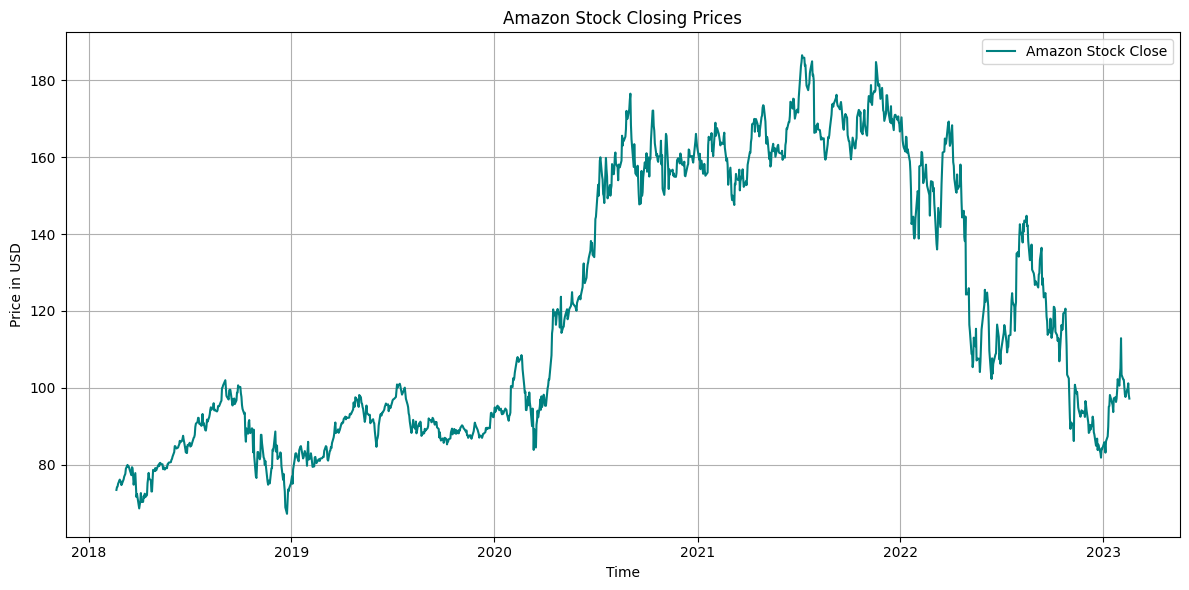

ADF Test p-value: 0.45297105465166737
KPSS Test p-value: 0.01
ADF p-value after differencing: 0.0
KPSS p-value after differencing: 0.1


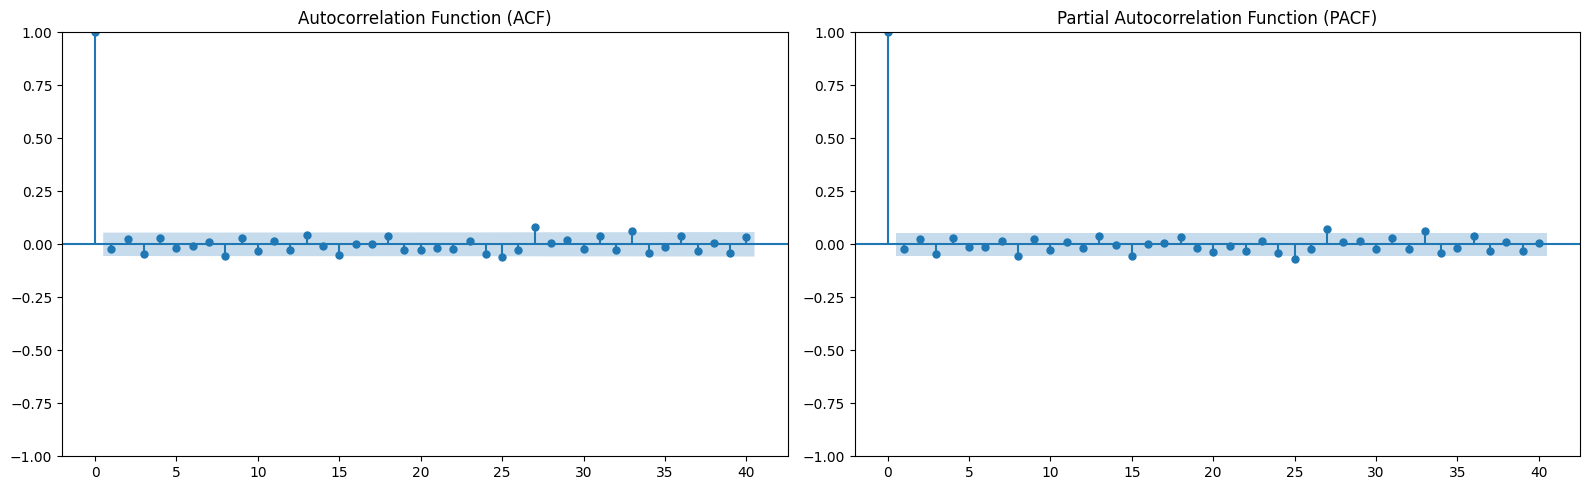

Best ARIMA order found: (2, 1, 2)
Evaluation Metrics on Backtest (Last 24 Points):
MAE : 2.9318
RMSE: 4.2158
MAPE: 0.0285


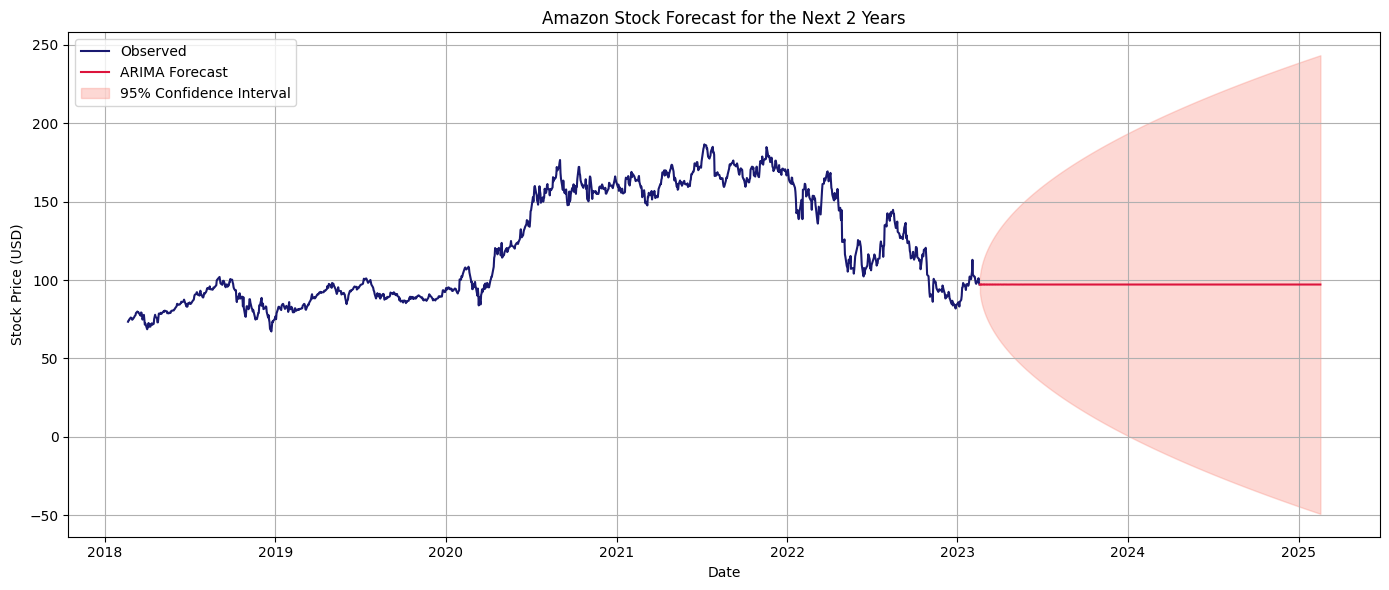

In [4]:
# --- Import Required Libraries for Time Series Forecasting ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# Step 1: Load Dataset and Plot Time Series
# ----------------------------------------
df_amazon = pd.read_csv("/content/drive/MyDrive/AMZN.csv")
df_amazon['Date'] = pd.to_datetime(df_amazon['Date'])
df_amazon.set_index('Date', inplace=True)

# Extract closing prices
ts_close = df_amazon[['Close']]

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(ts_close, color='teal', label='Amazon Stock Close')
plt.title('Amazon Stock Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------
# Step 2: Check for Stationarity (ADF & KPSS Tests)
# -----------------------------------------------
adf_p = adfuller(ts_close['Close'])[1]
kpss_p = kpss(ts_close['Close'], regression='c', nlags='auto')[1]

print("ADF Test p-value:", adf_p)
print("KPSS Test p-value:", kpss_p)

# -------------------------------------------------
# Step 3: Apply Differencing to Remove Trend/Seasonality
# -------------------------------------------------
ts_diff = ts_close.diff().dropna()

# Re-test stationarity after differencing
adf_diff_p = adfuller(ts_diff['Close'])[1]
kpss_diff_p = kpss(ts_diff['Close'], regression='c', nlags='auto')[1]

print("ADF p-value after differencing:", adf_diff_p)
print("KPSS p-value after differencing:", kpss_diff_p)

# ------------------------------------------------
# Step 4: Visualize ACF and PACF for Model Order Selection
# ------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(ts_diff, lags=40, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(ts_diff, lags=40, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Step 5: Grid Search for Best ARIMA(p,d,q) Using AIC
# -----------------------------------------------------
lowest_aic = float('inf')
optimal_order = None
optimal_model = None

for p in range(4):
    for q in range(4):
        try:
            temp_model = ARIMA(ts_close['Close'], order=(p, 1, q)).fit()
            if temp_model.aic < lowest_aic:
                lowest_aic = temp_model.aic
                optimal_order = (p, 1, q)
                optimal_model = temp_model
        except:
            continue

print("Best ARIMA order found:", optimal_order)

# -----------------------------------------------------------
# Step 6: Forecast Stock Prices for the Next 730 Days (2 Years)
# -----------------------------------------------------------
future_forecast = optimal_model.get_forecast(steps=730)
future_values = future_forecast.predicted_mean
confidence_bounds = future_forecast.conf_int()

last_observed_date = ts_close.index[-1]
forecast_dates = pd.date_range(start=last_observed_date + pd.Timedelta(days=1), periods=730)

# -----------------------------------------------------
# Step 7: Backtesting on the Last 24 Observations
# -----------------------------------------------------
n_test = 24
train_series = ts_close[:-n_test]
test_series = ts_close[-n_test:]

model_train = ARIMA(train_series['Close'], order=optimal_order).fit()
forecast_test = model_train.get_forecast(steps=n_test)
predicted_test = forecast_test.predicted_mean

# ------------------------------------------
# Step 8: Compute Evaluation Metrics
# ------------------------------------------
actual_values = test_series['Close'].values
predicted_values = predicted_test.values

mae_score = mean_absolute_error(actual_values, predicted_values)
rmse_score = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape_score = mean_absolute_percentage_error(actual_values, predicted_values)

print("Evaluation Metrics on Backtest (Last 24 Points):")
print("MAE :", round(mae_score, 4))
print("RMSE:", round(rmse_score, 4))
print("MAPE:", round(mape_score, 4))

# -----------------------------------------------------
# Step 9: Visualize the Full Forecast with Confidence Bands
# -----------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(ts_close.index, ts_close['Close'], label='Observed', color='midnightblue')
plt.plot(forecast_dates, future_values, label='ARIMA Forecast', color='crimson')
plt.fill_between(forecast_dates,
                 confidence_bounds.iloc[:, 0],
                 confidence_bounds.iloc[:, 1],
                 color='salmon', alpha=0.3, label='95% Confidence Interval')
plt.title('Amazon Stock Forecast for the Next 2 Years')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**RNN Model**

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1687 - val_loss: 0.0066
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0040 - val_loss: 0.0055
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0

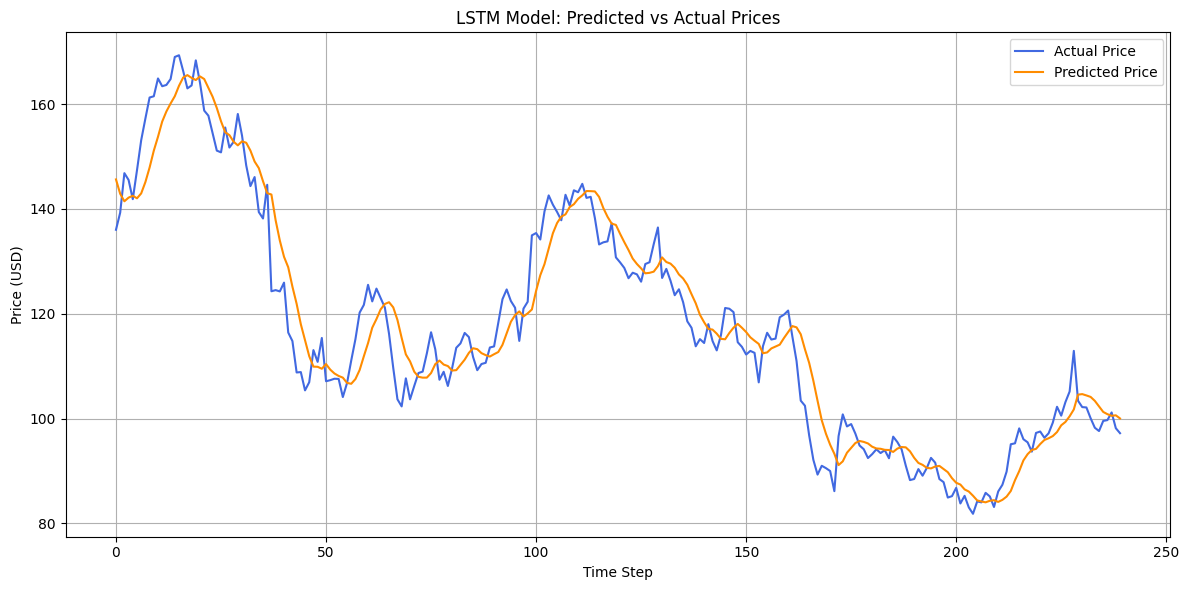

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM Model Forecasting Performance:
MAE : 4.5554
RMSE: 5.7973
MAPE: 0.0392


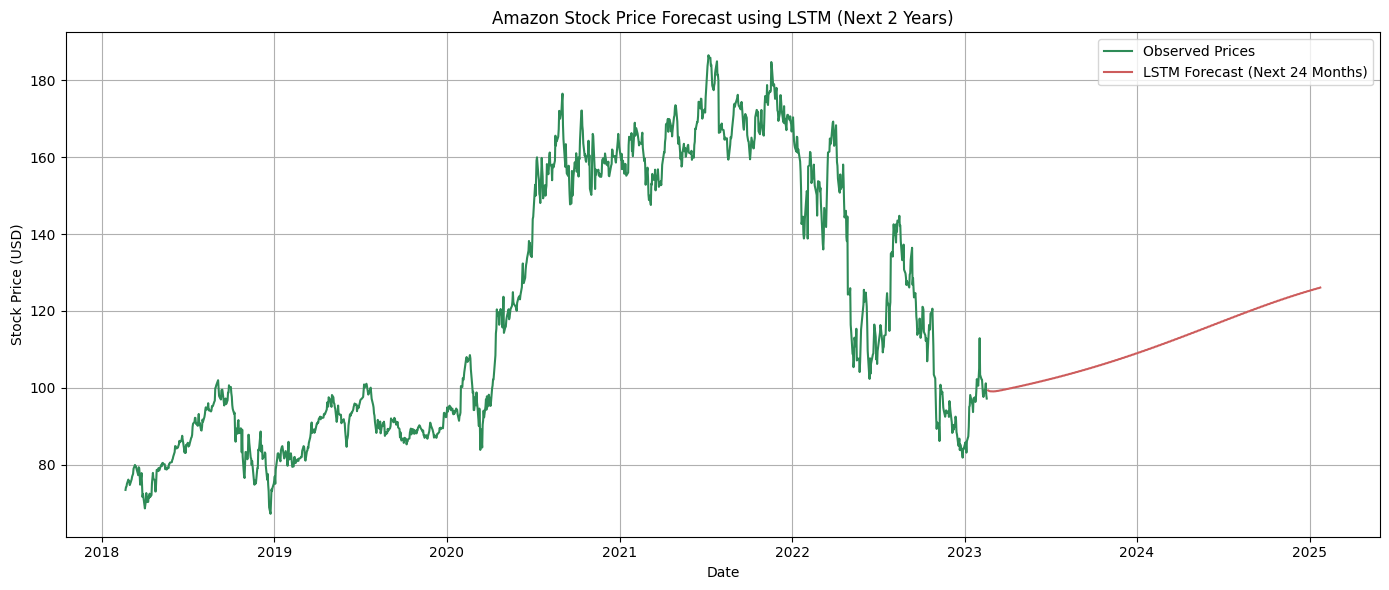

In [5]:
# ----------------------------------------
# Import Required Libraries
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# ----------------------------------------
# Load and Prepare the Dataset
# ----------------------------------------
df_amzn = pd.read_csv("/content/drive/MyDrive/AMZN.csv")
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])
df_amzn.set_index('Date', inplace=True)
ts_close = df_amzn[['Close']].copy()

# Scale closing prices to range [0, 1]
scaler = MinMaxScaler()
ts_close['Close'] = scaler.fit_transform(ts_close[['Close']])

# ----------------------------------------
# Generate Sequential Data for LSTM Input
# ----------------------------------------
def generate_sequences(series, window_size):
    inputs, outputs = [], []
    for i in range(len(series) - window_size):
        inputs.append(series[i:i+window_size])
        outputs.append(series[i+window_size])
    return np.array(inputs), np.array(outputs)

window_length = 60
X_seq, y_seq = generate_sequences(ts_close['Close'].values, window_length)
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

# ----------------------------------------
# Split Data for Training and Evaluation
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# ----------------------------------------
# Define and Fit the LSTM Model
# ----------------------------------------
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ----------------------------------------
# Visualize Actual vs Predicted Prices
# ----------------------------------------
def plot_lstm_predictions(model, X_test, y_test, label="LSTM"):
    predictions = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Price', color='royalblue')
    plt.plot(scaler.inverse_transform(predictions), label='Predicted Price', color='darkorange')
    plt.title(f"{label} Model: Predicted vs Actual Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_lstm_predictions(lstm_model, X_test, y_test)

# ----------------------------------------
# Compute Model Performance Metrics
# ----------------------------------------
y_pred_scaled = lstm_model.predict(X_test)
true_vals = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_vals = scaler.inverse_transform(y_pred_scaled).flatten()

mae_score = mean_absolute_error(true_vals, predicted_vals)
rmse_score = np.sqrt(mean_squared_error(true_vals, predicted_vals))
mape_score = mean_absolute_percentage_error(true_vals, predicted_vals)

print("LSTM Model Forecasting Performance:")
print("MAE :", round(mae_score, 4))
print("RMSE:", round(rmse_score, 4))
print("MAPE:", round(mape_score, 4))

# ----------------------------------------
# Forecast Next 504 Business Days (~2 Years)
# ----------------------------------------
def make_future_forecast(model, last_data, forecast_horizon=504, window_size=60):
    recent_seq = last_data[-window_size:].reshape(1, window_size, 1)
    forecast_output = []

    for _ in range(forecast_horizon):
        next_step = model.predict(recent_seq, verbose=0)[0][0]
        forecast_output.append(next_step)
        recent_seq = np.append(recent_seq[:, 1:, :], [[[next_step]]], axis=1)

    return scaler.inverse_transform(np.array(forecast_output).reshape(-1, 1))

forecast_prices = make_future_forecast(lstm_model, ts_close['Close'].values, forecast_horizon=504)

# ----------------------------------------
# Create Forecast Timeline and Plot Results
# ----------------------------------------
forecast_index = pd.date_range(start=ts_close.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(ts_close.index, scaler.inverse_transform(ts_close['Close'].values.reshape(-1, 1)),
         label='Observed Prices', color='seagreen')
plt.plot(forecast_index, forecast_prices, label='LSTM Forecast (Next 24 Months)', color='indianred')
plt.title('Amazon Stock Price Forecast using LSTM (Next 2 Years)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.2162 - val_loss: 0.0095
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 9.4604e-04 - val_loss: 0.0016
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 7.3880e-04 - val_loss: 0.0017
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 6.4240e-04 - val_loss: 0.0015
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.2936e-04 - val_loss: 0.0015
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.2254e-04 - val_loss: 0.0014
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.8422e-04 - val_loss: 0.0014
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.1131e-04 - val_loss: 0.0014
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.7920e-04 - val_loss: 0.0013
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.8238e-04 - val_loss: 0.0013
Epoch 12/50
30/30 ━━━━━━━━━

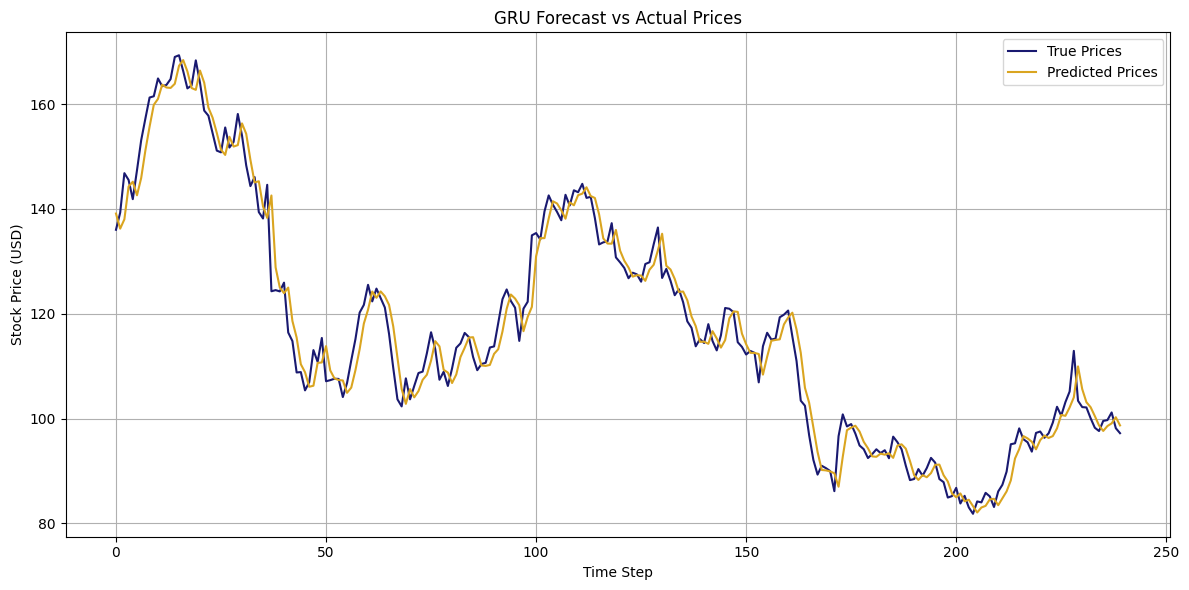

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
GRU Model Forecast Evaluation:
MAE : 2.9902
RMSE: 3.883
MAPE: 0.0258


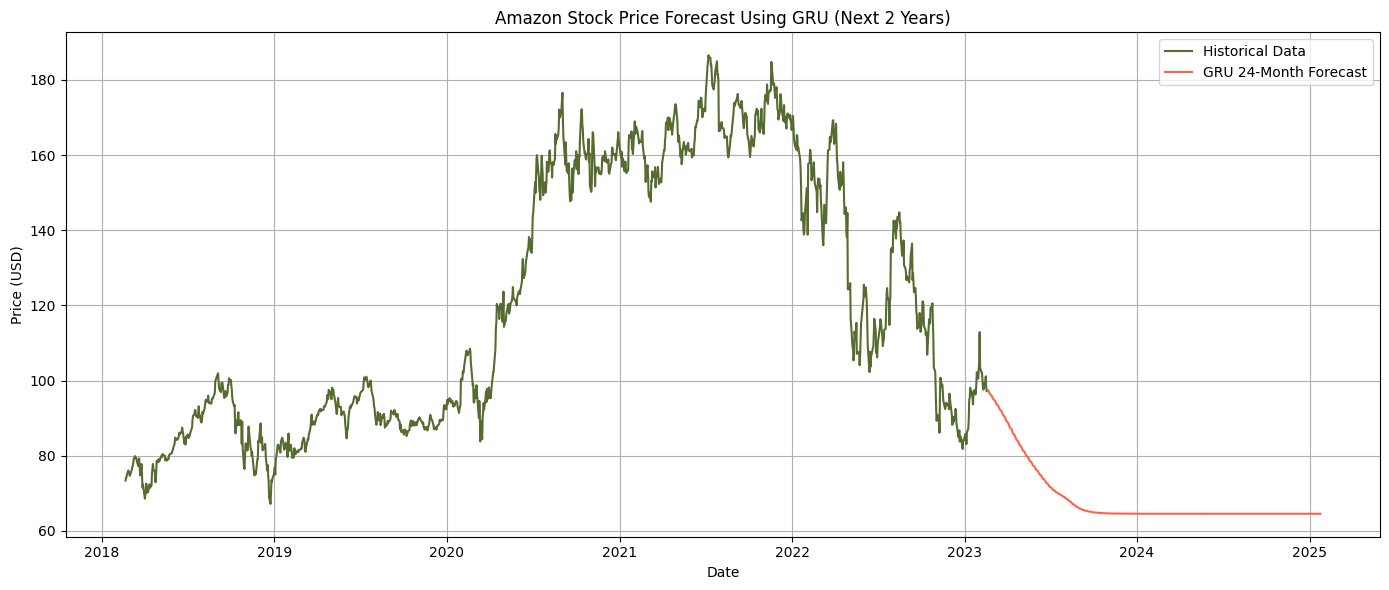

In [6]:
# ----------------------------------------
# Import Essential Libraries
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

# ----------------------------------------
# Load and Normalize Amazon Stock Data
# ----------------------------------------
df_amazon = pd.read_csv("/content/drive/MyDrive/AMZN.csv")
df_amazon['Date'] = pd.to_datetime(df_amazon['Date'])
df_amazon.set_index('Date', inplace=True)
ts_close = df_amazon[['Close']].copy()

# Apply Min-Max Scaling to Close Prices
scaler = MinMaxScaler()
ts_close['Close'] = scaler.fit_transform(ts_close[['Close']])

# ----------------------------------------
# Create Input Sequences for GRU Model
# ----------------------------------------
def generate_sequences(data_series, window_size):
    X_seq, y_seq = [], []
    for i in range(len(data_series) - window_size):
        X_seq.append(data_series[i:i+window_size])
        y_seq.append(data_series[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_len = 60
X_data, y_data = generate_sequences(ts_close['Close'].values, window_len)
X_data = X_data.reshape((X_data.shape[0], X_data.shape[1], 1))

# ----------------------------------------
# Split Dataset into Training and Test Sets
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)

# ----------------------------------------
# Define and Train the GRU Network
# ----------------------------------------
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ----------------------------------------
# Plot Actual vs Predicted Prices
# ----------------------------------------
def visualize_predictions(model, X_val, y_val, model_name="GRU"):
    predicted_vals = model.predict(X_val)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_val.reshape(-1, 1)), label='True Prices', color='midnightblue')
    plt.plot(scaler.inverse_transform(predicted_vals), label='Predicted Prices', color='goldenrod')
    plt.title(f"{model_name} Forecast vs Actual Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Stock Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_predictions(gru_model, X_test, y_test)

# ----------------------------------------
# Evaluate Forecast Accuracy
# ----------------------------------------
predicted_scaled = gru_model.predict(X_test)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
forecasted_prices = scaler.inverse_transform(predicted_scaled).flatten()

mae_score = mean_absolute_error(actual_prices, forecasted_prices)
rmse_score = np.sqrt(mean_squared_error(actual_prices, forecasted_prices))
mape_score = mean_absolute_percentage_error(actual_prices, forecasted_prices)

print("GRU Model Forecast Evaluation:")
print("MAE :", round(mae_score, 4))
print("RMSE:", round(rmse_score, 4))
print("MAPE:", round(mape_score, 4))

# ----------------------------------------
# Forecast Future Stock Prices (24 Months)
# ----------------------------------------
def predict_future_series(model, input_data, steps=504, window_size=60):
    recent_input = input_data[-window_size:].reshape(1, window_size, 1)
    forecast_list = []

    for _ in range(steps):
        next_prediction = model.predict(recent_input, verbose=0)[0][0]
        forecast_list.append(next_prediction)
        recent_input = np.append(recent_input[:, 1:, :], [[[next_prediction]]], axis=1)

    return scaler.inverse_transform(np.array(forecast_list).reshape(-1, 1))

future_values = predict_future_series(gru_model, ts_close['Close'].values, steps=504)

# ----------------------------------------
# Generate Future Date Index and Plot Forecast
# ----------------------------------------
forecast_dates = pd.date_range(start=ts_close.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(ts_close.index, scaler.inverse_transform(ts_close['Close'].values.reshape(-1, 1)),
         label='Historical Data', color='darkolivegreen')
plt.plot(forecast_dates, future_values, label='GRU 24-Month Forecast', color='tomato')
plt.title('Amazon Stock Price Forecast Using GRU (Next 2 Years)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
